In [1]:
from datetime import datetime, timedelta
from typing import Any, Dict, List, Optional
import torch
from pathlib import Path
import numpy as np
from numpy import nan
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from scipy.stats import entropy as scipy_entropy

In [2]:
infiles=[#'/Users/rosssponholtz/data/gendata/results-copilot/synthetic_conditional_ehr_1000.csv',
#'/Users/rosssponholtz/data/gendata/results-copilot/synthetic_ehr_group_based_1000.csv',
#'/Users/rosssponholtz/data/gendata/results-copilot/15_synthetic_ehr_10k.csv',
#'/Users/rosssponholtz/data/gendata/results-o4mini/100recordoutput.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/10recordoutput-synthetic-conditional.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/100recordoutput-synthetic.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/100recordoutput.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/10recordoutput-synthetic-conditional.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/10recordoutput-synthetic-grouped.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/10recordoutput-synthetic.txt',
'/Users/rosssponholtz/data/gendata/results-o4mini/10recordoutput.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/100recordoutput-conditional.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/100recordoutput-naive.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/100recordoutput-synthetic.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10recordoutput-conditional.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10recordoutput-naive.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10recordoutput-synthetic.txt',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/10_naive.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/10_synthetic-conditional.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/100_naive.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/100_synthetic-conditional.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/100_synthetic-group.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/1000_naive.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/10cols/1000_synthetic-conditional.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/15cols/10_naive.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/15cols/10_synthetic.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/15cols/100_naive.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/15cols/100_synthetic.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/15cols/1000_naive.csv',
'/Users/rosssponholtz/data/gendata/results-gpt4.1/15cols/1000_synthetic.csv'
'/Users/rosssponholtz/data/gendata/results-gpt4.1/20cols/naive.csv',
'/Users/rosssponholtz/code/project/results-copilot/naive_ehr_10.csv',
'/Users/rosssponholtz/code/project/results-copilot/naive_ehr_100.csv',
'/Users/rosssponholtz/code/project/results-copilot/naive_ehr_1000.csv',
'/Users/rosssponholtz/code/project/results-copilot/naive_ehr_10000.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_conditional_ehr_10.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_conditional_ehr_100.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_conditional_ehr_1000.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_ehr_10.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_ehr_100.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_ehr_1000.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_ehr_group_based_10.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_ehr_group_based_100.csv',
'/Users/rosssponholtz/code/project/results-copilot/synthetic_ehr_group_based_1000.csv',]
infiles=['/Users/rosssponholtz/code/project/results-generator/synthetic_ehr_10000.csv',
'/Users/rosssponholtz/code/project/results-generator/synthetic_ehr.csv',
'/Users/rosssponholtz/code/project/results-generator/synthetic_10000.csv',
'/Users/rosssponholtz/code/project/results-generator/group_10000.csv']
infiles=['/Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-10col.csv',
         '/Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-15col.csv',
         '/Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-20col.csv']
infiles=['/Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-10col.csv',
         '/Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-15col.csv',
         '/Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-20col.csv']



In [3]:
param_grid = {
    'n_estimators': [ 300],
    'max_depth': [  14],
    'learning_rate': [0.01],
    'subsample': [ 0.8, 0.9],
    'colsample_bytree': [0.4],
    'reg_alpha': [0.15],
    'reg_lambda': [ 0.15],
    'objective': ['binary:logistic']
}
DoHyperparameterTuning = False

if DoHyperparameterTuning:
    xgb = XGBClassifier(eval_metric='auc')
    random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=50, cv=3, scoring='roc_auc', verbose=1, random_state=42, n_jobs=-1)
    random_search.fit(dfX, dfy)

    print("Best parameters found: ", random_search.best_params_)
    print("Best accuracy found: ", random_search.best_score_)

In [4]:
def run_model(infile):
    dfX = pd.read_csv(infile)
    print(f"Loaded data from {infile} with shape {dfX.shape}")
    
    dfy = dfX[['mortality0']].copy()
    dfy["mortality"] = dfy["mortality0"].astype(int)
    dfy.drop(['mortality0'], axis=1, inplace=True)

    dfX.drop(['mortality0'], axis=1, inplace=True)
    dfX.drop(['patientunitstay'], axis=1, inplace=True)    
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=.2)

    #self.model = XGBClassifier(n_estimators=250, max_depth=9, learning_rate=0.01, subsample=0.6, colsample_bytree=0.4, reg_alpha=0.1, reg_lambda=0.1, objective='binary:logistic')      
    model = XGBClassifier(n_estimators=300, max_depth=14, learning_rate=0.01, subsample=0.8, colsample_bytree=0.4, reg_alpha=0.15, reg_lambda=0.15, objective='binary:logistic')      
    #model = XGBClassifier()      
    model.fit(X_train, y_train)
    # make predictions
    preds = model.predict(X_test)
    # evaluate predictions
    model.score(X_test,y_test)

    print(f"Model: {model}")
    print(f"Score: {model.score(X_test, y_test)}")
    #print(f"Predictions: {model.predict(X_test)}")
    #print(f"Feature Importances: {self.model.feature_importances_}")
    #print(f"Selected Features: {self.model.selected_features}")
    print(f"Model: {model.get_params()}")
    print(f"Classification Report:\n{classification_report(y_test, preds)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, preds)}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, preds)}")

    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (class 1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                            estimator_name='XGBClassifier')
    display.plot()
    plt.title('ROC Curve')
    plt.show()
    #peform kl divergence with base data set


    return model

In [5]:
def normalize_distribution(values, bins=10):
    """Convert values to a normalized probability distribution."""
    counts, _ = np.histogram(values, bins=bins)
    # Add small epsilon to avoid log(0)
    counts = counts + 1e-10
    return counts / np.sum(counts)

def calculate_kl_divergence(file1, file2, column=None, bins=10):
    """
    Calculate Kullback-Leibler divergence between two CSV files.
    
    Parameters:
    -----------
    file1 : str
        Path to first CSV file
    file2 : str
        Path to second CSV file
    column : str, optional
        Column name to compare. If None, compares all numeric columns
    bins : int, default=10
        Number of bins for histogram discretization
    """
    # Load CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    print(f"Loaded {file1}: {df1.shape[0]} rows, {df1.shape[1]} columns")
    print(f"Loaded {file2}: {df2.shape[0]} rows, {df2.shape[1]} columns")
    print()
    
    # Get numeric columns
    numeric_cols1 = df1.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols2 = df2.select_dtypes(include=[np.number]).columns.tolist()
    
    if column:
        # Compare specific column
        if column not in numeric_cols1 or column not in numeric_cols2:
            print(f"Error: Column '{column}' not found in both files or not numeric")
            return
        
        columns_to_compare = [column]
    else:
        # Find common numeric columns
        columns_to_compare = list(set(numeric_cols1) & set(numeric_cols2))
        if not columns_to_compare:
            print("No common numeric columns found between the two files")
            return
    
    print(f"Comparing {len(columns_to_compare)} column(s):")
    print()
    
    # Calculate KL divergence for each column
    total_kl = 0
    col_count = 0
    for i, col in enumerate(columns_to_compare):
        try:
            values1 = df1[col].dropna().values
            values2 = df2[col].dropna().values
            
            # Normalize to distributions
            p = normalize_distribution(values1, bins=bins)
            q = normalize_distribution(values2, bins=bins)
            
            # Calculate KL divergence: D_KL(P || Q)
            kl_div = scipy_entropy(p, q)
            total_kl += kl_div
            col_count += 1
            print(f"Column #{i}: {col}")
            print(f"  File 1 - min: {values1.min():.4f}, max: {values1.max():.4f}, mean: {values1.mean():.4f}")
            print(f"  File 2 - min: {values2.min():.4f}, max: {values2.max():.4f}, mean: {values2.mean():.4f}")
            print(f"  KL Divergence (File1 || File2): {kl_div:.6f}")
            print()
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
            print()
    
    # Print summary
    print(f"Average KL Divergence across {col_count} column(s): {total_kl / col_count:.6f}")
    print(f"Total KL Divergence: {total_kl:.6f}")


Loaded data from /Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-10col.csv with shape (9838, 12)
Error processing /Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-10col.csv: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]
Loaded data from /Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-15col.csv with shape (10000, 17)
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_wei

/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


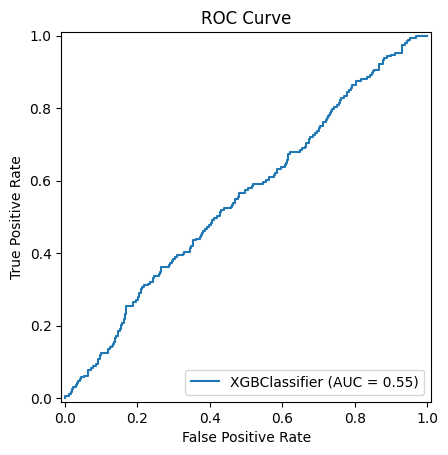

Loaded /Users/rosssponholtz/data/eicu-combined/combined_samples.csv: 159984 rows, 78 columns
Loaded /Users/rosssponholtz/data/gendata/results-copilot/copilot-naive-15col.csv: 10000 rows, 17 columns

Comparing 17 column(s):

Column #0: padiastolic_first
  File 1 - min: -21.0000, max: 317.0000, mean: 17.5568
  File 2 - min: 1730.7980, max: 100183497.1910, mean: 49980471.4146
  KL Divergence (File1 || File2): 1.751730

Column #1: pasystolic_first
  File 1 - min: -16.0000, max: 317.0000, mean: 35.1407
  File 2 - min: 11957.7030, max: 100163633.6180, mean: 50493790.6848
  KL Divergence (File1 || File2): 1.870339

Column #2: lactate_first
  File 1 - min: 0.0000, max: 36.7000, mean: 2.6136
  File 2 - min: 22262.6030, max: 100182910.3640, mean: 50107882.8061
  KL Divergence (File1 || File2): 1.630334

Column #3: bun_last
  File 1 - min: 0.8000, max: 298.0000, mean: 25.0737
  File 2 - min: 6407.7990, max: 100149637.2180, mean: 50163204.5138
  KL Divergence (File1 || File2): 1.530109

Column #4:

In [6]:
for infile in infiles:
    try:
        run_model(infile)
        calculate_kl_divergence('/Users/rosssponholtz/data/eicu-combined/combined_samples.csv', infile)
    except Exception as e:
        print(f"Error processing {infile}: {e}")